# PyTorch Workflow

ref: https://www.learnpytorch.io/01_pytorch_workflow/

In [1]:
what_were_covering = {
    1: "data (prep and load)",
    2: "build a model",
    3: "train a model",
    4: "inference and evaluation",
    5: "save and load a model",
    6: "putting it all together"
}

what_were_covering

{1: 'data (prep and load)',
 2: 'build a model',
 3: 'train a model',
 4: 'inference and evaluation',
 5: 'save and load a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn # nn contains all pytorch building blocks for neural nets
import matplotlib.pyplot as plt

torch.__version__

'2.3.1+cu121'

In [3]:
# 1. data
what_were_covering[1]

'data (prep and load)'

## 1. Data (prep and load)

Data can be anything really

* Tabular data
* Images
* Videos
* Audio
* Text

ML is a game of 2 parts
1. Get data into numerical representation
2. Build a model to learn patterns in that representation

In [4]:
# make some artificial data using a linear equation (y = mx + b) with known parameters

# known parameters
weight = 0.7 # m
bias = 0.3 # b

# create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], len(X), y[:10], len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 50,
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50)

In [5]:
# split data into training and testing sets

train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data, and compares predictions
  """
  plt.figure(figsize=(10,7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

  # plot testing data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

  # are there predictions?
  if predictions is not None:
    # plot if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions ")

  plt.legend(prop={"size": 14})

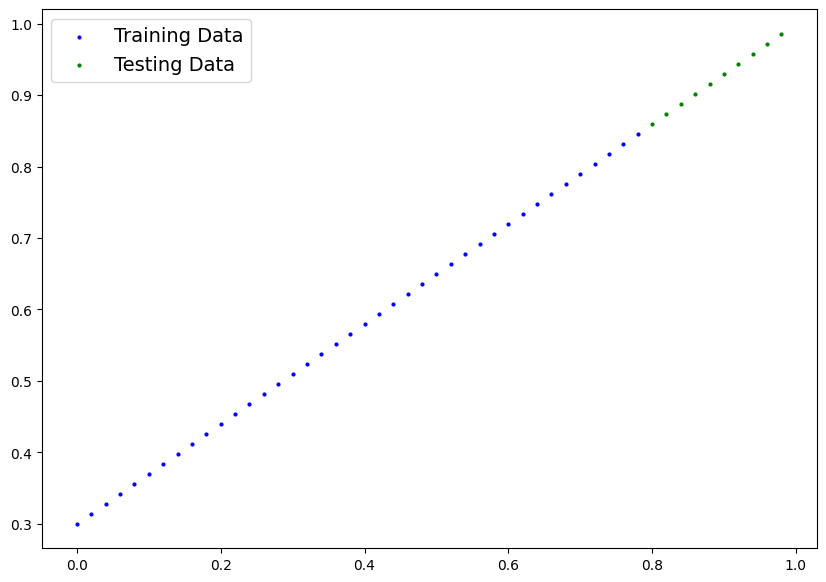

In [7]:
plot_predictions()

## 2. Build a model

Build a NN model that can capture a simple linear relationship

1. start with random values (weight and bias)
2. train and adjust parameters to get closer to ideal values (gradient descent and back-prop)

In [8]:
# create linear regression model class

class LinearRegressionModel(nn.Module): # every model inherits from nn.module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True, # default is True, gradient descent can update this
                                            dtype=torch.float)) # default is float, pytorch loves float32

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # forward method to define the computation in the model - always required!
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

### PyTorch model building essentials

* torch.nn - contains all building blocks for computational graphs and NN's
* torch.nn.Parameter - what parameters should our model try to learn - often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - base class for all NN modules. If you subclass it, you must overwrite the forward method
* torch.optim - this is where the optimizers in PyTorch live, they help with gradient descent
* def forward() - All nn.Module subclasses require this to be overwritten - this method defines what happens in the forward computation

https://pytorch.org/tutorials/beginner/ptcheat.html

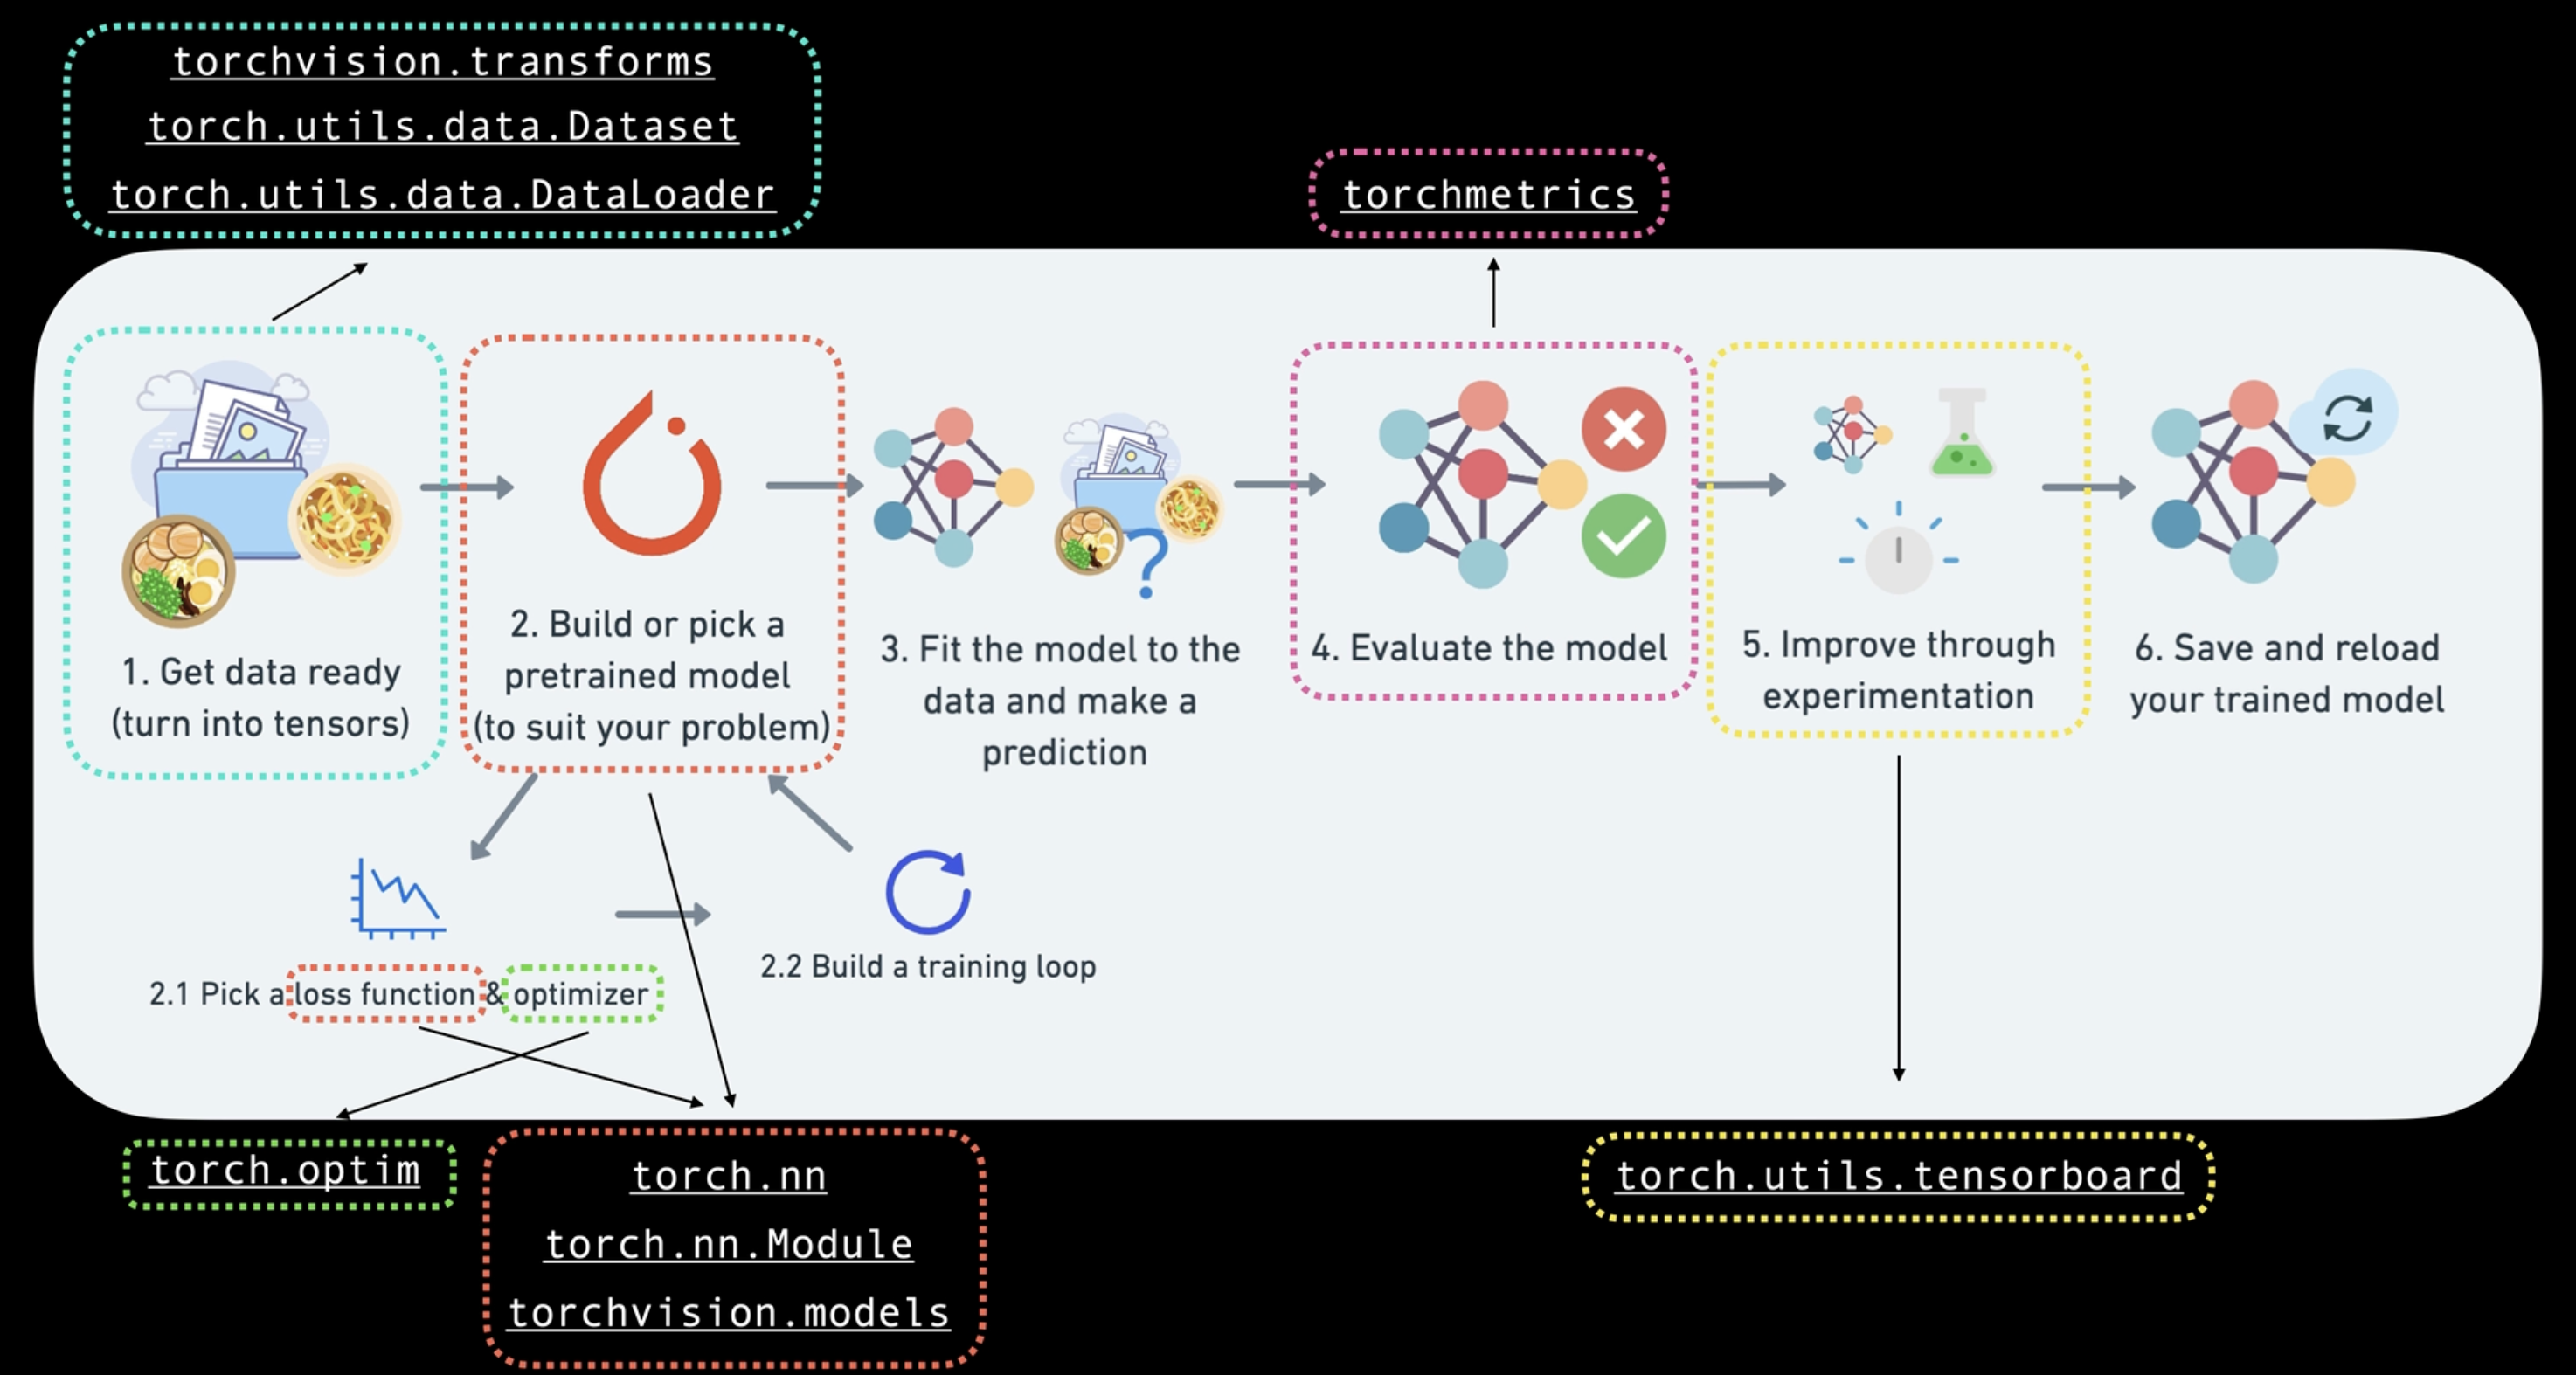

### Checking the contents of our PyTorch model

* looking inside of our model using the .parameters() method

In [9]:
# create random seed
torch.manual_seed(42)

# instantiate model
model_0 = LinearRegressionModel()

# check out parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Make a prediction using `torch.inference_mode()`

* pass data thru the model, generate a prediction (.forward() method), and compare to truth



In [11]:
# can do it this way...
y_preds = model_0(X_test)

print(y_preds)

# OR!

# make preds
with torch.inference_mode():
  y_preds = model_0(X_test)
  # why the inference mode context manager?
  # - inference mode doesn't calculate and store the gradient
  # - this speeds up computation!
  # - so, use inference_mode for predictions, and don't use it for training
  # - note the difference in printed outputs below


print('\n',y_preds)

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

 tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


In [12]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

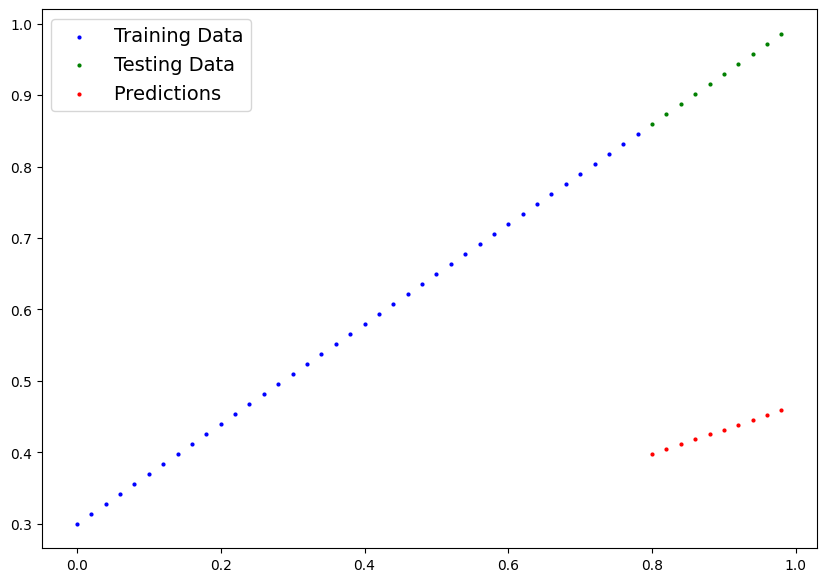

In [13]:
plot_predictions(predictions=y_preds)

## 3. Train the model

The idea of training is for the model move from initial (unknown) parameters to some known parameters.

In other words, from a poor representation to a better representation of the data

* In order to measure how wrong our model is, we must use a loss function - (loss, cost, criterion)


<hr>

So what do we need to train?

* **Loss Function** : A function to measure how distant model predictions are from optimal outputs

* **Optimizer** : Tells model how to update its internal parameters to best lower the cost base on the result of the loss function

Specific to PyTorch, we also need:

* A training loop
* A testing loop

In [14]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [15]:
# init loss function
loss_fn = nn.L1Loss()

# init an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # specify model params to modify
                            lr=0.005) # learning rate


In [16]:
print(loss_fn)
print(optimizer)

L1Loss()
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### Build a training and testing loop

Things we need:

0. Loop thru the data (epochs) and ...
1. Forward pass to make predictions (batches)
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

In [17]:
# epoch - a loop thru a complete dataset
epochs = 1000

# Tracking model progress - "experiments"
epoch_count = []
loss_value = []
test_loss_value = []

### Training
# 0. loop thru data
for epoch in range(epochs):
  # set the model context manager to training_mode
  model_0.train() # turns on gradient tracking

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate loss - preds first, then labels - (pred, target)
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad (works with steps 4 and 5)
  optimizer.zero_grad()

  # 4. Perform backprop on the loss wrt model parameters
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # if this wasn't zeroed out every step, it would compound changes and over-update


  ### Testing - typically written elswhere
  model_0.eval() # turns off things not needed outside of training (e.g., dropout, batchnorm)
  with torch.inference_mode(): # turns off gradient tracking - (torch.no_grad() is deprecated equivalent)
    # 1. do a forward pass
    test_pred = model_0(X_test)

    # 2. calculate test lost
    test_loss = loss_fn(test_pred, y_test)

  # print whats happening within the loop
  if epoch %10 == 0:
    epoch_count.append(epoch)
    loss_value.append(loss.detach().numpy())
    test_loss_value.append(test_loss.numpy())
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | MAE Loss: {loss} | MAE Test Loss: {test_loss}")
    print(model_0.state_dict())




Epoch: 0 | MAE Loss: 0.31288138031959534 | MAE Test Loss: 0.4878006875514984
OrderedDict([('weights', tensor([0.3386])), ('bias', tensor([0.1338]))])
Epoch: 100 | MAE Loss: 0.041651852428913116 | MAE Test Loss: 0.10024197399616241
OrderedDict([('weights', tensor([0.4929])), ('bias', tensor([0.3841]))])
Epoch: 200 | MAE Loss: 0.024415848776698112 | MAE Test Loss: 0.056821130216121674
OrderedDict([('weights', tensor([0.5793])), ('bias', tensor([0.3506]))])
Epoch: 300 | MAE Loss: 0.007245116867125034 | MAE Test Loss: 0.016491109505295753
OrderedDict([('weights', tensor([0.6648])), ('bias', tensor([0.3148]))])
Epoch: 400 | MAE Loss: 0.001977377338334918 | MAE Test Loss: 0.0024690269492566586
OrderedDict([('weights', tensor([0.6974])), ('bias', tensor([0.3048]))])
Epoch: 500 | MAE Loss: 0.001977377338334918 | MAE Test Loss: 0.0024690269492566586
OrderedDict([('weights', tensor([0.6974])), ('bias', tensor([0.3048]))])
Epoch: 600 | MAE Loss: 0.001977377338334918 | MAE Test Loss: 0.00246902694

In [18]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6954])), ('bias', tensor([0.2998]))])

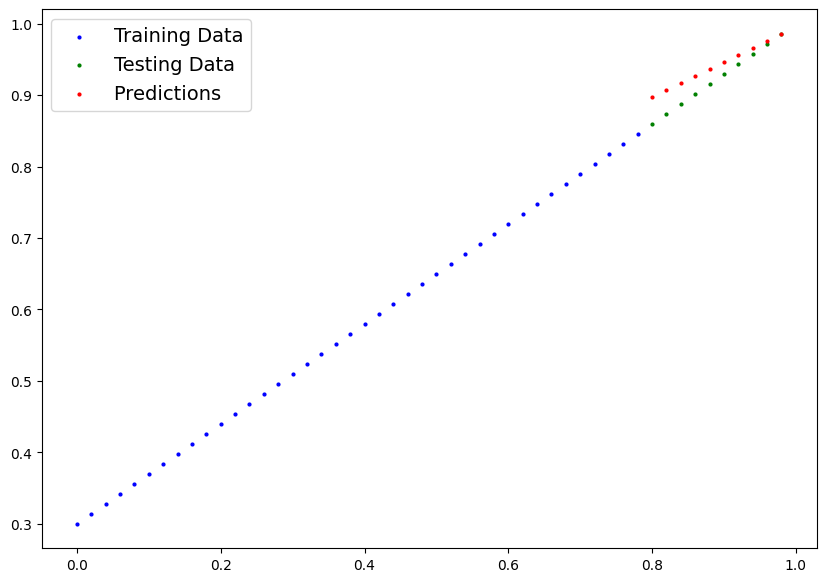

In [19]:
with torch.inference_mode():
  y_preds_new = model_0(y_test)

plot_predictions(predictions=y_preds_new)

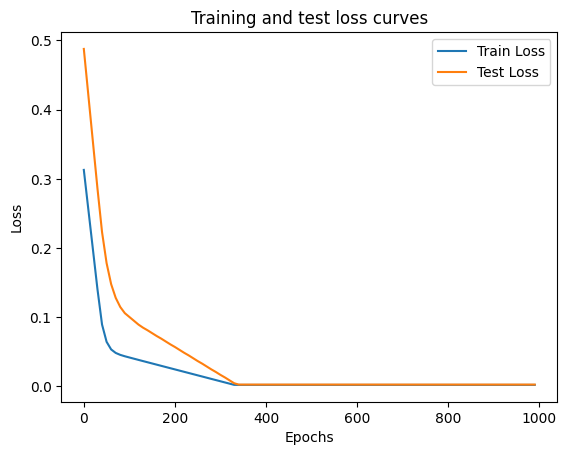

In [20]:
plt.plot(epoch_count, loss_value, label="Train Loss")
plt.plot(epoch_count, test_loss_value, label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

## Saving a PyTorch Model

There are 3 methods to know about for saving and loading PyTorch models

1. `torch.save()` - save a torch object in pickle format
2. `torch.load()` - load a saved torch object (also pickle format)
3. `torch.nn.Module.load_state_dict()` - load a model
s saved state dictionary

  * Notice that the load_state_dict() function takes a dictionary object, NOT a path to a saved object. This means that you must deserialize the saved state_dict before you pass it to the load_state_dict() function. For example, you CANNOT load using model.load_state_dict(PATH).


Example:

```
# save model
torch.save(model.state_dict(), PATH)

# load model
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
```



From docs:
* When saving a model for inference, it is only necessary to save the trained model’s learned parameters. Saving the model’s state_dict with the torch.save() function will give you the most flexibility for restoring the model later, which is why it is the recommended method for saving models.

* A common PyTorch convention is to save models using either a .pt or .pth file extension.

* Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.



https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models

In [21]:
# Note that saving to google colab results in TEMPORARY storage!
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow.pt" # or .pth
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Save location: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Save location: models/01_pytorch_workflow.pt


In [22]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1568 Aug 12 17:51 01_pytorch_workflow.pt


In [23]:
# Reload the model from storage
# 1. Instantiate model class
model_reloaded = LinearRegressionModel()
print(list(model_reloaded.parameters()))

# 2. Load parameters with nested calls
model_reloaded.load_state_dict(torch.load(MODEL_SAVE_PATH))
print(list(model_reloaded.parameters()))

[Parameter containing:
tensor([0.2345], requires_grad=True), Parameter containing:
tensor([0.2303], requires_grad=True)]
[Parameter containing:
tensor([0.6954], requires_grad=True), Parameter containing:
tensor([0.2998], requires_grad=True)]


In [24]:
model_reloaded.eval()
with torch.inference_mode():
  reloaded_preds = model_reloaded(X_test)
  og_preds = model_0(X_test)

In [25]:
reloaded_preds, og_preds

(tensor([[0.8561],
         [0.8701],
         [0.8840],
         [0.8979],
         [0.9118],
         [0.9257],
         [0.9396],
         [0.9535],
         [0.9674],
         [0.9813]]),
 tensor([[0.8561],
         [0.8701],
         [0.8840],
         [0.8979],
         [0.9118],
         [0.9257],
         [0.9396],
         [0.9535],
         [0.9674],
         [0.9813]]))

In [26]:
reloaded_preds == og_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Putting it all together



In [27]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# check torch version
torch.__version__

'2.3.1+cu121'

In [28]:
# Create device agnostic code
# i.e., if we have access to a GPU, then use it, otherwise choose CPU

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [29]:
# 1. Data - replicate y = mx + b

# init params
weight = -0.2
bias = 0.9

# create vals
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = X * weight + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.9000],
         [0.8960],
         [0.8920],
         [0.8880],
         [0.8840],
         [0.8800],
         [0.8760],
         [0.8720],
         [0.8680],
         [0.8640]]))

In [30]:
# split data
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(len(X_train), len(X_test))

40 10


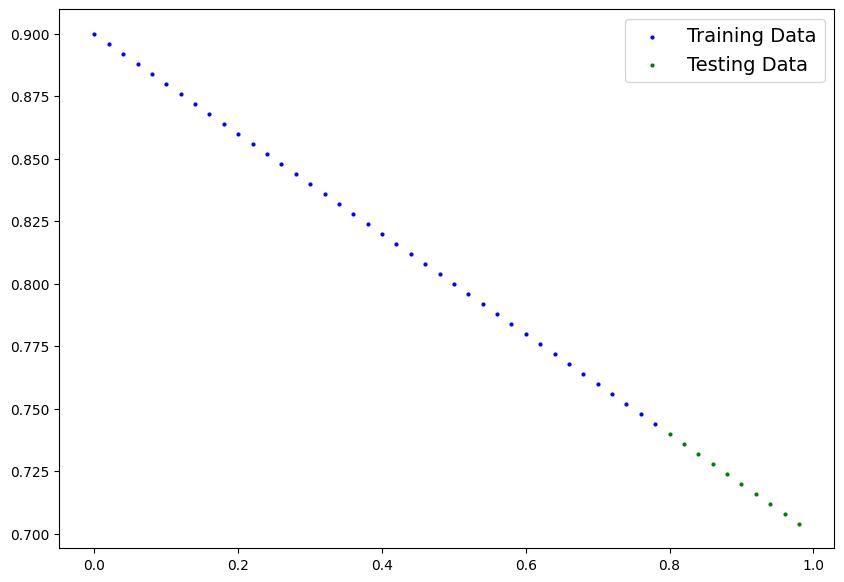

In [31]:
# plot data
plot_predictions(X_train, y_train, X_test, y_test)

In [32]:
# 2. Build a model

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1))
    self.bias = nn.Parameter(torch.randn(1))

  def forward(self, x):
    return self.weights * x + self.bias


# OR

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x):
    return self.linear_layer(x)

In [33]:
# 3. Train a model
torch.manual_seed(6)

'''
Things we need:

Loop thru the data (epochs) and ...
Forward pass to make predictions (batches)
Calculate the loss
Optimizer zero grad
Loss backward (backpropagation)
Optimizer step (gradient descent)
'''

# a. instantiate model, then choose loss function and optimizer

# model instantiation
#model_1 = LinearRegressionModel()
model_1 = LinearRegressionModelV2()

# loss
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.005)

In [34]:
# b. set up training loop

epochs = 1000

epoch_count = []
train_loss_record = []
test_loss_record = []


for i in range(epochs):
  # 0. set model to train mode
  model_1.train()

  # 1. forward pass to make predictions
  train_preds = model_1(X_train)

  # 2. Calculate loss for training and testing
  train_loss = loss_fn(train_preds, y_train)
  train_loss_record.append(train_loss.detach().numpy())

  # 3. zero the optimizer gradient
  optimizer.zero_grad()

  # 4. backprop
  train_loss.backward()

  # 5. gradient descent (optimizer step)
  optimizer.step()

  # TEST DATA LOSS
  model_1.eval()
  with torch.inference_mode():
    # 1. test preds
    test_preds = model_1(X_test)

    # 2. test loss
    test_loss = loss_fn(test_preds, y_test)
    test_loss_record.append(test_loss.detach().numpy())

  epoch_count.append(i)

  # print progress
  if i % 100 == 0:
    print(f"Epoch: {i} | Train Loss: {train_loss_record[-1]} | Test Loss: {test_loss_record[-1]} ")



Epoch: 0 | Train Loss: 0.657934844493866 | Test Loss: 0.47900182008743286 
Epoch: 100 | Train Loss: 0.13554662466049194 | Test Loss: 0.149309903383255 
Epoch: 200 | Train Loss: 0.09544745087623596 | Test Loss: 0.2162615954875946 
Epoch: 300 | Train Loss: 0.07812239974737167 | Test Loss: 0.1824558824300766 
Epoch: 400 | Train Loss: 0.06095351651310921 | Test Loss: 0.1421240121126175 
Epoch: 500 | Train Loss: 0.04377983510494232 | Test Loss: 0.10213582217693329 
Epoch: 600 | Train Loss: 0.026610326021909714 | Test Loss: 0.061804138123989105 
Epoch: 700 | Train Loss: 0.009437290020287037 | Test Loss: 0.021815871819853783 
Epoch: 800 | Train Loss: 0.0022104650270193815 | Test Loss: 0.005534446332603693 
Epoch: 900 | Train Loss: 0.0022104650270193815 | Test Loss: 0.005534446332603693 


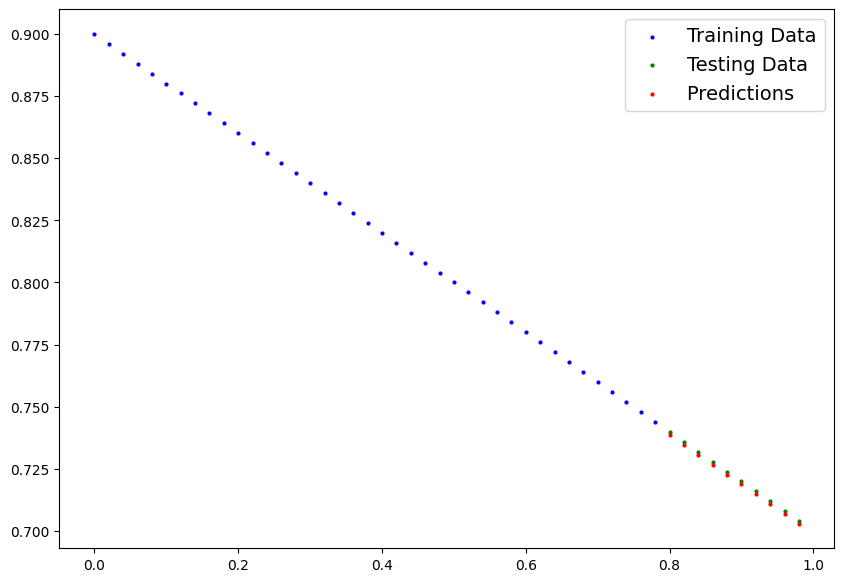

In [35]:
with torch.inference_mode():
  y_preds = model_1(X_test)

plot_predictions(X_train, y_train, X_test, y_test, predictions=y_preds)

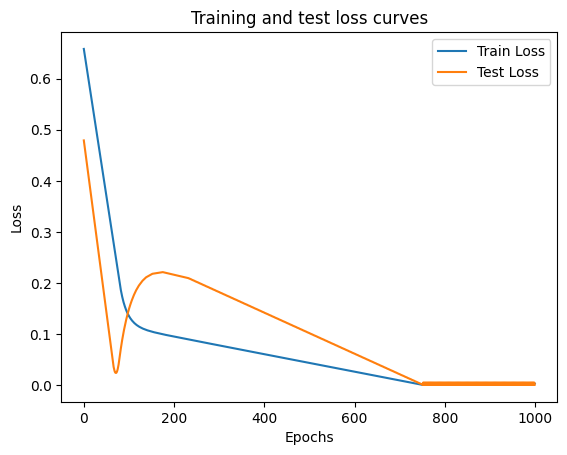

In [36]:
plt.plot(epoch_count, train_loss_record, label="Train Loss")
plt.plot(epoch_count, test_loss_record, label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [39]:
# Note that saving to google colab results in TEMPORARY storage!
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "model_1_pytorch_workflow.pt" # or .pth
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Save location: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Save location: models/model_1_pytorch_workflow.pt


In [40]:
# Reload the model from storage
# 1. Instantiate model class
model_reloaded = LinearRegressionModelV2()
print(list(model_reloaded.parameters()))

# 2. Load parameters with nested calls
model_reloaded.load_state_dict(torch.load(MODEL_SAVE_PATH))
print(list(model_reloaded.parameters()))

[Parameter containing:
tensor([[-0.5307]], requires_grad=True), Parameter containing:
tensor([-0.1016], requires_grad=True)]
[Parameter containing:
tensor([[-0.1980]], requires_grad=True), Parameter containing:
tensor([0.8970], requires_grad=True)]
